In [28]:

import numpy as np
# from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
import re
from tqdm import trange
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from sklearn.datasets import fetch_openml

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [29]:
import sys
sys.path.append("../")
from src.CNN import CNN, compute_accuracy_metrics, multiclass_accuracy_metrics, list2onehot, onehot2list

In [30]:
import random as random

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# X = X.values  ### Uncomment this line if you are having type errors in plotting. It is loading as a pandas dataframe, but our indexing is for numpy array. 
X = X / 255.

#since the datasize is too big, I am just going to subsample them. 

#randomlist = random.sample(range(0, 70000), 3000)

#X=X[randomlist]
#y=y[randomlist]
print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.  
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

In [31]:
def random_padding(img, thickness=1):
    # img = a x b image 
    [a,b] = img.shape
    Y = np.zeros(shape=[a+thickness, b+thickness])
    r_loc = np.random.choice(np.arange(thickness+1))
    c_loc = np.random.choice(np.arange(thickness+1))
    Y[r_loc:r_loc+a, c_loc:c_loc+b] = img
    return Y

In [32]:

def sample_multiclass_MNIST_padding(list_digits=['0','1', '2'], full_MNIST=[X,y], padding_thickness=10):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    # pad each 28 x 28 image with zeros so that it has now "padding_thickness" more rows and columns
    # The original image is superimposed at a uniformly chosen location 
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)
    
    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in trange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        img_padded = random_padding(X01[i,:].reshape(28,28), thickness=padding_thickness)
        img_padded_vec = img_padded.reshape(1,-1)
        if U<0.8:
            X_train.append(img_padded_vec[0,:].copy())
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(img_padded_vec[0,:].copy())
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test

In [33]:
#multiclass logistic regression
def fit_MLR_GD(Y, H, W0=None, sub_iter=100, stopping_diff=0.01):
        '''
        Convex optimization algorithm for Multiclass Logistic Regression using Gradient Descent 
        Y = (n x k), H = (p x n) (\Phi in lecture note), W = (p x k)
        Multiclass Logistic Regression: Y ~ vector of discrete RVs with PMF = sigmoid(H.T @ W)
        MLE -->
        Find \hat{W} = argmin_W ( sum_j ( log(1+exp(H_j.T @ W) ) - Y.T @ H.T @ W ) )
        '''
        k = Y.shape[1] # number of classes 
        if W0 is None:
            W0 = np.random.rand(H.shape[0],k) #If initial coefficients W0 is None, randomly initialize  
            
        W1 = W0.copy()
        i = 0
        grad = np.ones(W0.shape)
        while (i < sub_iter) and (np.linalg.norm(grad) > stopping_diff):
            Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y
            # grad = H @ (Q - Y).T + alpha * np.ones(W0.shape[1])
            grad = H @ (Q - Y)
            W1 = W1 - (np.log(i+1) / (((i + 1) ** (0.5)))) * grad
            i = i + 1
            # print('iter %i, grad_norm %f' %(i, np.linalg.norm(grad)))
        return W1


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:00<00:00, 36795.91it/s]
<ipython-input-33-a2dc3c5a0d40>:18: RuntimeWarning: overflow encountered in exp
  Q = 1/(1+np.exp(-H.T @ W1))  # probability matrix, same shape as Y


!!! confusion_mx [[ 7  0  0  0  0]
 [ 0 11  0  0  0]
 [ 0  0 12  0  0]
 [ 0  0  0  9  0]
 [ 0  0  0  0 11]]
!!! Accuracy 1.0
!!! confusion_mx [[1194    0   60   61   42]
 [   0 1530   14   29    5]
 [  24   47 1152  110  117]
 [  24   25   69 1259   75]
 [   6   11    5    9 1340]]
!!! Accuracy 0.89830743618202


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:01<00:00, 29986.31it/s]


!!! confusion_mx [[11  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0  8  0  0]
 [ 0  0  0  8  0]
 [ 0  0  0  0 10]]
!!! Accuracy 1.0
!!! confusion_mx [[913  88 226  65 113]
 [210 965 177  15 166]
 [300 214 600  86 244]
 [403 220 281 325 140]
 [150 264  76  18 828]]
!!! Accuracy 0.5123465500211655


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:01<00:00, 29014.26it/s]


!!! confusion_mx [[10  0  0  0  0]
 [ 0 11  0  0  0]
 [ 0  0  7  0  0]
 [ 0  0  0 17  0]
 [ 0  0  0  0  5]]
!!! Accuracy 1.0
!!! confusion_mx [[357 149 239 631  41]
 [298 529  52 622  76]
 [253 236 225 687  21]
 [223 256 121 757  35]
 [233 340 156 497 102]]
!!! Accuracy 0.27606502242152464


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:01<00:00, 24133.75it/s]


!!! confusion_mx [[12  0  0  0  0]
 [ 0  8  0  0  0]
 [ 0  0 10  0  0]
 [ 0  0  0 12  0]
 [ 0  0  0  0  8]]
!!! Accuracy 1.0
!!! confusion_mx [[522  20 166 457 234]
 [510 136 218 482 228]
 [470  32 189 505 196]
 [494  15 146 581 227]
 [487  39 170 399 265]]
!!! Accuracy 0.23553144129104062


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:01<00:00, 31567.61it/s]


!!! confusion_mx [[21  0  0  0  0]
 [ 0 26  0  0  0]
 [ 0  0 19  0  0]
 [ 0  0  0 16  0]
 [ 0  0  0  0 18]]
!!! Accuracy 1.0
!!! confusion_mx [[1318    1    1   22    1]
 [   2 1598   22   22    1]
 [ 151   58 1117   61   41]
 [ 124   25   41 1251    9]
 [  31   23   23   45 1273]]
!!! Accuracy 0.903043657898361


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:01<00:00, 28431.08it/s]


!!! confusion_mx [[21  0  0  0  0]
 [ 0 17  0  0  0]
 [ 0  0 15  0  0]
 [ 0  0  0 21  0]
 [ 0  0  0  0 26]]
!!! Accuracy 1.0
!!! confusion_mx [[954  48 139 108 122]
 [193 867 137 250 131]
 [206 114 523 246 307]
 [287 143 255 626 112]
 [126  79 142  35 955]]
!!! Accuracy 0.5524278676988037


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:01<00:00, 28604.84it/s]


!!! confusion_mx [[20  0  0  0  0]
 [ 0 22  0  0  0]
 [ 0  0 22  0  0]
 [ 0  0  0 19  0]
 [ 0  0  0  0 17]]
!!! Accuracy 1.0
!!! confusion_mx [[606 284 279 115  59]
 [303 696 297 127 130]
 [461 291 393 178  90]
 [366 385 299 261  87]
 [364 375 231  99 320]]
!!! Accuracy 0.32074408117249154


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:01<00:00, 23752.52it/s]


!!! confusion_mx [[24  0  0  0  0]
 [ 0 16  0  0  0]
 [ 0  0 24  0  0]
 [ 0  0  0 19  0]
 [ 0  0  0  0 17]]
!!! Accuracy 1.0
!!! confusion_mx [[749 107 270 212  61]
 [537 338 252 276 180]
 [617  60 327 301  89]
 [587  90 271 316 105]
 [570 144 229 259 205]]
!!! Accuracy 0.27055369127516776


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:00<00:00, 36055.71it/s]


!!! confusion_mx [[24  0  0  0  0]
 [ 0 41  0  0  0]
 [ 0  0 52  0  0]
 [ 0  0  0 41  0]
 [ 0  0  0  0 42]]
!!! Accuracy 1.0
!!! confusion_mx [[1285    0   24  115    1]
 [   0 1485   53   26    0]
 [  14   14 1231  108   26]
 [   1   10   56 1383    8]
 [   6   25   35  102 1147]]
!!! Accuracy 0.9127882599580712


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:01<00:00, 30186.07it/s]


!!! confusion_mx [[32  0  0  0  0]
 [ 0 54  0  0  0]
 [ 0  0 30  0  0]
 [ 0  0  0 43  0]
 [ 0  0  0  0 41]]
!!! Accuracy 1.0
!!! confusion_mx [[ 930   58  159  113  131]
 [  83 1244   22  147   49]
 [ 144  138  638  339  206]
 [ 163  178  199  807   97]
 [  75  192   97  112  905]]
!!! Accuracy 0.6260725159147523


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:01<00:00, 27274.40it/s]


!!! confusion_mx [[37  0  0  0  0]
 [ 0 48  0  0  0]
 [ 0  0 38  0  0]
 [ 0  0  0 41  0]
 [ 0  0  0  0 36]]
!!! Accuracy 1.0
!!! confusion_mx [[541 118 312 250 192]
 [132 910 151 177 194]
 [286 191 369 350 217]
 [293 240 276 515 172]
 [174 232 176 249 561]]
!!! Accuracy 0.39791151415223963


100%|█████████████████████████████████████████████████████████████████████████| 35735/35735 [00:01<00:00, 24574.76it/s]


!!! confusion_mx [[37  0  0  0  0]
 [ 0 47  0  0  0]
 [ 0  0 38  0  0]
 [ 0  0  0 41  0]
 [ 0  0  0  0 37]]
!!! Accuracy 1.0
!!! confusion_mx [[435 167 371 290 155]
 [136 749 154 328 169]
 [243 175 422 347 239]
 [252 210 352 416 196]
 [249 258 271 349 235]]
!!! Accuracy 0.3148716517857143


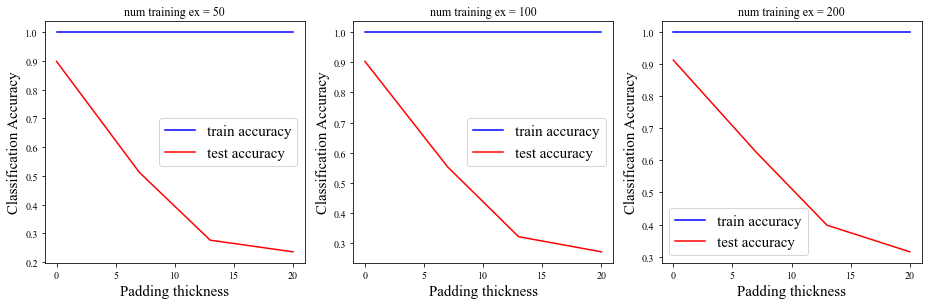

In [34]:
from sklearn.utils.extmath import softmax
list_digits=['0', '1', '2','3','4']
padding_list=[0,7,13,20]
train_size_list=[50,100,200]


#make plot
ncols = len(train_size_list)
fig, ax =plt.subplots(nrows=1, ncols=ncols, figsize=[13,5])

for t in np.arange(len(train_size_list)):
    accuracy_list_test = []
    accuracy_list_train = []
    
    train_size = train_size_list[t]
    
    for thickness in padding_list:
        X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=list_digits, full_MNIST = [X,y], padding_thickness=thickness)
        idx = np.random.choice(np.arange(len(y_train)),train_size)
        X_train0 = X_train[idx,:]/np.max(X_train)
        y_train0 = y_train[idx,:]
        H_train = np.vstack((np.ones(X_train0.shape[0]), X_train0.T))  # add first row of 1's for bias features 
        W = fit_MLR_GD(Y=y_train0, H=H_train)
        Q_train = softmax(H_train.T @ W.copy())
        H_test = np.vstack((np.ones(X_test.shape[0]), X_test.T))
        Q_test = softmax(H_test.T @ W.copy()) # predicted probabilities for y_test # Uses sklearn's softmax for numerical stability

        results_train = multiclass_accuracy_metrics(Y_test=y_train0, P_pred=Q_train)
        results_test = multiclass_accuracy_metrics(Y_test=y_test, P_pred=Q_test)
        
        accuracy_list_train.append(results_train.get('Accuracy'))
        accuracy_list_test.append(results_test.get('Accuracy'))
        
    ax[t].plot(padding_list, accuracy_list_train, color='blue', label="train accuracy")
    ax[t].plot(padding_list, accuracy_list_test, color='red', label="test accuracy")
    ax[t].set_xlabel('Padding thickness', fontsize=15)
    ax[t].set_ylabel('Classification Accuracy', fontsize=15)
    ax[t].title.set_text("num training ex = %i" % (train_size)) 
    ax[t].legend(fontsize=15)

plt.tight_layout(rect=[0, 0.03, 1, 0.9])